In [98]:
import re
import os
import json
from collections import Counter
import pandas as pd
import numpy as np
import itertools

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('omw-1.4')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import matplotlib.pyplot as plt

from gensim import corpora
from gensim.models.ldamodel import LdaModel

settings = {
  'model': {
    'version': 1,
    'cache': False,
  },
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danpasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/danpasse/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Step 1

- build dataset

In [75]:
documents = []
with open('../../data/disney/job_descriptions.json', 'r') as reader:
  for description in json.loads(reader.read()):
    items = [
      item['text']
      for item in description['sections']
      if item['section'] == 'Basic Qualifications' or item['section'] == 'Preferred Qualifications'
    ]

    if len(items) == 0:
      continue

    qualification = {
      'cat_id': description['cat_id'],
      'job_id': description['job_id'],
      'step_1': items
    }

    documents.append(qualification)

documents[0]

{'cat_id': 391,
 'job_id': 19757793040,
 'step_1': ['* You are passionate about your area of expertise, deeply inquisitive and open minded, informed, but not limited, by your domain of expertise.\n* You enjoy intellectual debate.\n* You are comfortable guiding other team members but willing to get your hands dirty and help build research systems when needed\n* You are driven to perform research that is not simply novel, but deeply impactful to the company and society have a deep desire to reduce the research to practice in the form of prototypes and technology demonstrators.\n* You are excited by the platform provided by Disney to connect with children and guests of all ages to have a positive impact on the world.\n* You have a deep sensitivity for ethical use of technology and data.\n* You thrive in a fast-paced collaborative environment.\n* You are self-directed and independent, but open to constructive feedback.\n* You are a team player, able to work in collaborative interdisciplina

### Step 2

- text to sentences

In [76]:
def transform_text(text):
  def clean_sentence(sentence):
    sentence = re.sub(r'[`\'’#]', '', sentence)
    sentence = re.sub(r'[,.!?:;"“”%_–-]', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence.strip()

  text = re.sub(r'(e\.g\.|\/)', ' ', text)
  text = re.sub(r'etc\.', 'etc', text)
  text = re.sub(r'[*•●"()]', ' ', text)
  text = re.sub(r'&', ' and ', text)

  return [ clean_sentence(sentence) for sentence in sent_tokenize(text.lower()) ]

for document in documents:
  document['step_2'] = []
  for section_text in document['step_1']:
    document['step_2'].extend(transform_text(section_text))

print(documents[0]['step_1'][0])
print()
print(documents[0]['step_2'][0])

* You are passionate about your area of expertise, deeply inquisitive and open minded, informed, but not limited, by your domain of expertise.
* You enjoy intellectual debate.
* You are comfortable guiding other team members but willing to get your hands dirty and help build research systems when needed
* You are driven to perform research that is not simply novel, but deeply impactful to the company and society have a deep desire to reduce the research to practice in the form of prototypes and technology demonstrators.
* You are excited by the platform provided by Disney to connect with children and guests of all ages to have a positive impact on the world.
* You have a deep sensitivity for ethical use of technology and data.
* You thrive in a fast-paced collaborative environment.
* You are self-directed and independent, but open to constructive feedback.
* You are a team player, able to work in collaborative interdisciplinary groups
* You are willing to take the time necessary to und

### Step 3

- sentences to individual tokens

In [77]:
wnl = WordNetLemmatizer()
trash = list(stopwords.words('english'))

def tokenize(sentence):
  return [
    wnl.lemmatize(token)
    for token
    in word_tokenize(sentence)
    if not token in trash
  ]

for document in documents:
  document['step_3'] = []
  for sentence in document['step_2']:
    document['step_3'].append(tokenize(sentence))
  
print(documents[0]['step_2'][3])
print()
print(documents[0]['step_3'][3])

you are excited by the platform provided by disney to connect with children and guests of all ages to have a positive impact on the world

['excited', 'platform', 'provided', 'disney', 'connect', 'child', 'guest', 'age', 'positive', 'impact', 'world']


### Step 4

- build ngrams

In [78]:
n_gram_ranges = [2, 3]

def format(tup):
  return '_'.join(tup)

for document in documents:
  document['step_4'] = []
  for tokens in document['step_3']:
    sentence_grams = []
    for n in n_gram_ranges:
      sentence_grams.extend([ format(tup) for tup in nltk.ngrams(tokens, n)])
    
    document['step_4'].append(sentence_grams)

print(documents[0]['step_3'][0])
print()
print(documents[0]['step_4'][0])

['passionate', 'area', 'expertise', 'deeply', 'inquisitive', 'open', 'minded', 'informed', 'limited', 'domain', 'expertise']

['passionate_area', 'area_expertise', 'expertise_deeply', 'deeply_inquisitive', 'inquisitive_open', 'open_minded', 'minded_informed', 'informed_limited', 'limited_domain', 'domain_expertise', 'passionate_area_expertise', 'area_expertise_deeply', 'expertise_deeply_inquisitive', 'deeply_inquisitive_open', 'inquisitive_open_minded', 'open_minded_informed', 'minded_informed_limited', 'informed_limited_domain', 'limited_domain_expertise']


### Step 5

- final document

In [79]:
for document in documents:
  document['step_5'] = []
  for tokens in document['step_4']:
    document['step_5'].extend(tokens)
  
print(documents[0]['step_4'][0])
print()
print(documents[0]['step_5'][:5])

['passionate_area', 'area_expertise', 'expertise_deeply', 'deeply_inquisitive', 'inquisitive_open', 'open_minded', 'minded_informed', 'informed_limited', 'limited_domain', 'domain_expertise', 'passionate_area_expertise', 'area_expertise_deeply', 'expertise_deeply_inquisitive', 'deeply_inquisitive_open', 'inquisitive_open_minded', 'open_minded_informed', 'minded_informed_limited', 'informed_limited_domain', 'limited_domain_expertise']

['passionate_area', 'area_expertise', 'expertise_deeply', 'deeply_inquisitive', 'inquisitive_open']


### Step 6

- filter out ngrams

In [80]:
document_sentences = [ document['step_3'] for document in documents ]
qualifications = [ document['step_5'] for document in documents ]

In [81]:
bag_words = Counter(
  itertools.chain(*qualifications)
)

n = 5
print(np.array(bag_words.most_common(n)))
print()
print(np.array(bag_words.most_common()[-(n+1):-1]))

[['communication_skill' '70']
 ['year_experience' '54']
 ['experience_working' '45']
 ['skill_ability' '38']
 ['ability_work' '36']]

[['includes_respect_variety' '1']
 ['respect_variety_voice' '1']
 ['variety_voice_identity' '1']
 ['voice_identity_background' '1']
 ['identity_background_experience' '1']]


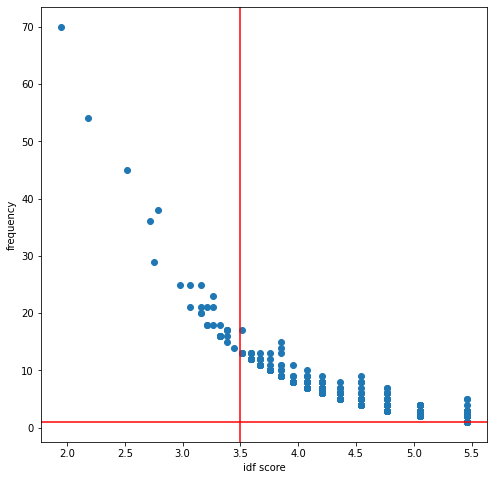

In [82]:
dump_data_out = False
dump_out_cv_features_file_path = '../../data/disney/cv_features.txt'

model = Pipeline([
  ('cv', CountVectorizer(preprocessor=lambda a: a, tokenizer=lambda a: a)),
  ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True))
])

model.fit(qualifications)

if dump_data_out:
  with open(dump_out_cv_features_file_path, 'w') as trash:
    for tk in model.get_feature_names_out():
      trash.write(f'{tk}\n')
else:
  if os.path.exists(dump_out_cv_features_file_path):
    os.remove(dump_out_cv_features_file_path)

count_dataset = list(
  map(
    lambda a: (a[0], a[1], bag_words.get(a[0])),
    zip(model.get_feature_names_out(), model['tfidf'].idf_)
  )
)

x = list(map(lambda a: a[1], count_dataset)) ## idf
y = list(map(lambda a: a[2], count_dataset)) ## freq


fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y)
plt.xlabel('idf score')
plt.ylabel('frequency')

plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=3.5, color='r', linestyle='-')

plt.show()

In [83]:
stop_words = []
stop_words.extend(
  list(map(lambda a: a[0], filter(lambda a: a[1] < 3.5, count_dataset))) ## how common across the corpus
)
stop_words.extend(
  list(map(lambda a: a[0], filter(lambda a: a[2] == 1, count_dataset))) ## how common across the corpus
)

print(len(stop_words))
print(np.array(stop_words))

stop_words = { term: 0 for term in stop_words }

17683
['2_year' '5+_year' '5_year' ... 'zone_responsibility_must' 'zoom_working'
 'zoom_working_window']


In [84]:
def should_we_take(gram):
  if gram in stop_words:
    return False

  return True

for document in documents:
  document['final'] = [ token for token in document['step_5'] if should_we_take(token) ]
  
print(documents[0]['step_5'][:5])
print()
print(documents[0]['final'][:5])

['passionate_area', 'area_expertise', 'expertise_deeply', 'deeply_inquisitive', 'inquisitive_open']

['informed_limited', 'team_member', 'hand_dirty', 'help_build', 'driven_perform']


### Step 7

- lda

In [85]:
documents_to_process = [ document['final'] for document in documents ]
dictionary = corpora.Dictionary(documents_to_process)
document_term_matrix = [dictionary.doc2bow(doc) for doc in documents_to_process]

num_topics = 8

model = LdaModel(
  document_term_matrix,
  num_topics=num_topics,
  id2word=dictionary,
  passes=100,
)

In [86]:
print(np.array(model.print_topics(num_topics=num_topics, num_words=15)))

[['0'
  '0.003*"audio_video" + 0.003*"experience_building" + 0.003*"product_management" + 0.002*"video_player" + 0.002*"audio_video_lighting" + 0.002*"video_lighting" + 0.002*"management_experience" + 0.002*"guest_service" + 0.002*"programming_language" + 0.002*"experience_technical" + 0.002*"knowledge_experience" + 0.002*"youve_demonstrated" + 0.002*"video_streaming" + 0.002*"previous_experience" + 0.002*"software_development"']
 ['1'
  '0.003*"per_week" + 0.003*"full_availability" + 0.002*"including_night" + 0.002*"day_per" + 0.002*"day_per_week" + 0.002*"week_including" + 0.002*"week_including_night" + 0.002*"per_week_including" + 0.002*"availability_shift" + 0.002*"full_availability_shift" + 0.002*"part_team" + 0.002*"mathematics_statistic_economics" + 0.002*"economics_engineering" + 0.002*"mathematics_statistic" + 0.002*"statistic_economics_engineering"']
 ['2'
  '0.004*"method_experience" + 0.003*"disney_resort" + 0.003*"shanghai_disney_resort" + 0.003*"shanghai_disney" + 0.003*"

In [87]:
titles = {}

df = pd.read_csv('../../data/disney/jobs.csv')
for _, row in df.iterrows():
  cat_id = row['cat_id']
  job_id = row['job_id']

  titles[f'{cat_id}_{job_id}'] = row['title']

In [88]:
for document in documents:
    job_id = document['job_id']
    cat_id = document['cat_id']
    bow = dictionary.doc2bow(document['final'])
    topic = model.get_document_topics(bow)

    title = titles[f'{cat_id}_{job_id}']
    print(f'"{title}"', '->', *topic)

"Researcher, Disney Research Imagineering" -> (4, 0.9947909)
"Associate R&D Imagineer - Creative Technologist" -> (7, 0.97915393)
"R&D Imagineer Principal - Business Manager" -> (3, 0.9851651)
"R&D Imagineer Sr. - Mechanical Design Engineer" -> (3, 0.98906004)
"Sr. R&D Imagineer-TPM for Intelligent Interactive Character Studio" -> (3, 0.990689)
"Associate R&D Imagineer-Tools Software Engineer" -> (6, 0.96193016)
"Senior AI/ML Research Scientist, Disney Research Imagineering" -> (4, 0.9955575)
"Intern, Creative Design Related" -> (1, 0.9582714)
"Executive Assistant (Project Hire)" -> (5, 0.9582958)
"PH-Mechanical Engineer" -> (4, 0.97175884)
"Product Mgr Sr - Business" -> (0, 0.9485029)
"Show Mechanical Engineer Principal" -> (7, 0.9834793)
"PH-Graphic Fabrication Designer" -> (6, 0.9858839)
"PH- Associate Environmental Fabrication Designer" -> (6, 0.99088365)
"PH-Construction Manager Sr" -> (0, 0.9873136)
"WDI Special Effects & Illusion Development Internship–Summer/Fall 2022" -> (1, 0

### Save model

In [95]:
if settings['model']['cahce']:
  model_version = settings['model']['version']
  directory_path = f'../../data/disney/models/lda_v{model_version}/'
  if not os.path.exists(directory_path):
    os.mkdir(directory_path)

  model.save(f'{directory_path}/lda_v{model_version}')

  with open(f'{directory_path}/lda_v{model_version}_documents.csv', 'w') as output:
    output.write('cat_id,job_id\n')
    for cat_id, job_id in [(document['cat_id'], document['job_id']) for document in documents]:
      output.write(f'{cat_id},{job_id}\n')
  